# **Notebook: Image Registration and Data Integration for Crunch 1 and Crunch 2**

## **Objective**
This notebook focuses on preparing datasets for the Autoimmune Disease Machine Learning Challenge by addressing the following key tasks:
    1. **Image Registration**: Aligning unregistered images from Crunch 1 to the spatial transcriptomics coordinate system by inferring registration methods from Crunch 2.
2. **Data Integration**: Loading, validating, and processing datasets for seamless analysis and machine learning pipeline compatibility.

---

## **Steps in the Notebook**

### **1. Configuration Setup**
- Use `config.yaml` to dynamically load Crunch 1 and Crunch 2 settings such as data directories, processing parameters, and output paths.
- Centralize paths and parameters using the `ConfigLoader` utility for flexibility and reproducibility.

### **2. Data Loading**
- Employ the `DataLoader` utility to validate and load datasets across multiple formats (`.zarr`, `.csv`, `.h5ad`).
- Automatically detect and load required data files for Crunch 1 and Crunch 2 using parallel processing for efficiency.

### **3. Image Registration**

#### **Key Process**
- Images from Crunch 1 (**HE_original**) are currently unregistered, requiring alignment to the spatial transcriptomics coordinate system.
- Images from Crunch 2 (**HE_registered**) serve as a reference for the registration process.

#### **How Registration Works**
1. **Extract Reference Transformations**:
- Load the registered images (`HE_registered`) and unregistered images (`HE_original`) from Crunch 2.
- Compute the transformation matrix (e.g., affine transformation) that maps `HE_original` to `HE_registered`.
- Utilize image processing libraries such as `scipy`, `skimage`, or `spatialdata` to extract translation, rotation, scaling, and warping parameters.

2. **Apply Transformations to Crunch 1**:
- Load unregistered images (`HE_original`) from Crunch 1.
- Apply the transformations inferred from Crunch 2 to align Crunch 1 images to the spatial transcriptomics coordinate system.
- Validate the registration by checking the alignment visually or through spatial overlap metrics.

3. **Save Registered Images**:
- Save the newly registered Crunch 1 images to the designated output directory (defined in `config.yaml`).
- Ensure that the registered images are in the correct format and coordinate system for downstream analysis.

### **4. Save Registered Data**
- Store the registered images from Crunch 1 in the specified output directory.
- Validate the output to ensure compatibility with downstream tasks such as patch extraction, embedding generation, and regression analysis.

---

## **Key Features**
- **Automated Registration**: Dynamically infer and apply transformations for image registration.
    - **Reusable Framework**: Modular approach allows integration with other Crunch datasets or similar workflows.
- **Validation**: Ensure the accuracy of registration through alignment metrics or visual inspection.

---

## **Prerequisites**
- **Configuration File**: `config.yaml` with correct paths and processing parameters.
- **Libraries**: Ensure installation of libraries such as `numpy`, `spatialdata`, `skimage`, and `scipy`.

---

## **Expected Outcomes**
- Aligned images from Crunch 1 stored in the appropriate directory (`HE_registered` equivalent for Crunch 1).
- Ready-to-use datasets for machine learning workflows.


In [1]:
# Core Python Libraries
import os

# Data Manipulation
import numpy as np

# Spatial Data and Image Processing
import cv2  # OpenCV for advanced image registration

# Visualization
import matplotlib.pyplot as plt

# Machine Learning and Tensor Operations

# Utilities

# Challenge-Specific Utilities
from src.config.config_loader import ConfigLoader
from src.data_loader import DataLoader

# Threading and Parallelism


/home/secondbook5/micromamba/envs/autoimmune_ml/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


### **Step 1: Configuration Setup**
We dynamically load paths and parameters from the `config.yaml` file to ensure reproducibility and centralized management of key settings. This setup allows us to flexibly manage data directories, output paths, and other parameters for Crunch 1 and Crunch 2 datasets.


In [2]:
# Load the configuration file
config_path = "../../config.yaml"  # Adjust the relative path if necessary
config_loader = ConfigLoader(config_path)

# Select the Crunch (e.g., Crunch 1 for registering images)
crunch_name = "crunch1"

# Fetch paths from the configuration
raw_data_dir = config_loader.get_crunch_path(crunch_name, "raw_dir")
interim_dir = config_loader.get_crunch_path(crunch_name, "interim_dir")

# Create directories if they do not exist
os.makedirs(interim_dir, exist_ok=True)

# Print the setup information
print("Notebook started: Image Registration for Crunch 1")
print(f"Raw data directory: {raw_data_dir}")
print(f"Interim output directory: {interim_dir}")


Notebook started: Image Registration for Crunch 1
Raw data directory: /mnt/d/AutoImmuneML/broad-1-autoimmune-crunch1/data
Interim output directory: /mnt/d/AutoImmuneML/broad-1-autoimmune-crunch1/interim


### **Step 2: Data Loading**
We utilize the `DataLoader` utility to validate and load datasets in various formats (`.zarr`, `.csv`, `.h5ad`). For Crunch 1, we focus on loading the raw datasets containing `HE_original` and other relevant images for registration. This ensures all necessary data is preloaded for subsequent processing.


In [3]:
# Initialize the DataLoader
print("Initializing DataLoader...")
data_loader = DataLoader(config=config_loader, crunch_name="crunch1")

# Use the DataLoader to validate and load the raw dataset
print("Loading the dataset using DataLoader...")
try:
    # Validate and load the dataset
    dataset = data_loader.load_zarr(keys="raw_dir")
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Failed to load dataset: {e}")
    raise

# Confirm the keys in the loaded dataset
print("Available keys in the loaded dataset:")
print(list(dataset.keys()))

# Load the SpatialData object for a specific dataset (e.g., UC1_NI)
dataset_name = "UC1_NI.zarr"
if dataset_name in dataset:
    sdata = dataset[dataset_name]
    print(f"Dataset '{dataset_name}' successfully retrieved!")
else:
    print(f"Dataset '{dataset_name}' not found in the loaded data!")


Initializing DataLoader...
Loading the dataset using DataLoader...


Loading Zarr files: 100%|██████████| 1/1 [03:03<00:00, 183.78s/it]

Dataset loaded successfully!
Available keys in the loaded dataset:
['DC1.zarr', 'DC5.zarr', 'UC1_I.zarr', 'UC1_NI.zarr', 'UC6_I.zarr', 'UC6_NI.zarr', 'UC7_I.zarr', 'UC9_I.zarr']
Dataset 'UC1_NI.zarr' successfully retrieved!


### **Step 3: Data Exploration**
We examine the contents of the loaded dataset to identify available images (`HE_original`, `HE_nuc_original`) and tables (`anucleus`, etc.). This step helps us understand the dataset structure and confirms the presence of necessary components for image registration.


In [4]:
print("Images in the dataset:", sdata.images.keys())
print("Tables in the dataset:", sdata.tables.keys())


Images in the dataset: KeysView({'HE_nuc_original': <xarray.DataArray 'image' (c: 1, y: 21000, x: 22000)> Size: 2GB
dask.array<from-zarr, shape=(1, 21000, 22000), dtype=uint32, chunksize=(1, 5792, 5792), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 8B 0
  * y        (y) float64 168kB 0.5 1.5 2.5 3.5 ... 2.1e+04 2.1e+04 2.1e+04
  * x        (x) float64 176kB 0.5 1.5 2.5 3.5 ... 2.2e+04 2.2e+04 2.2e+04
Attributes:
    transform:  {'global': Identity }, 'HE_original': <xarray.DataArray 'image' (c: 3, y: 21000, x: 22000)> Size: 1GB
dask.array<from-zarr, shape=(3, 21000, 22000), dtype=uint8, chunksize=(3, 6688, 6688), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 24B 0 1 2
  * y        (y) float64 168kB 0.5 1.5 2.5 3.5 ... 2.1e+04 2.1e+04 2.1e+04
  * x        (x) float64 176kB 0.5 1.5 2.5 3.5 ... 2.2e+04 2.2e+04 2.2e+04
Attributes:
    transform:  {'global': Identity }})
Tables in the dataset: KeysView({'anucleus': AnnData object with n_obs × n_vars = 80037 × 

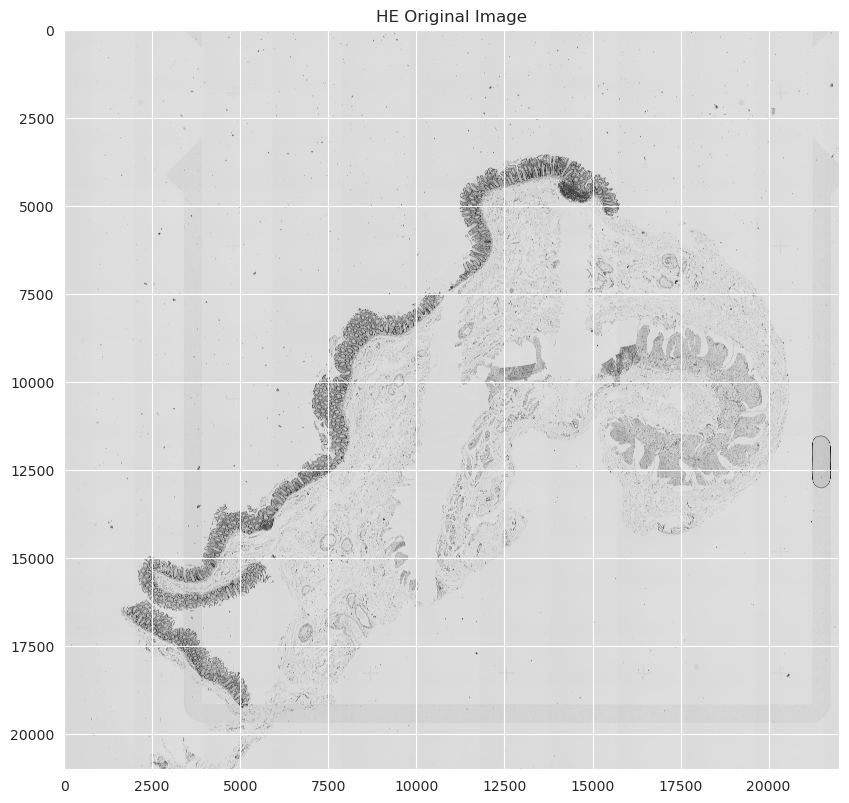

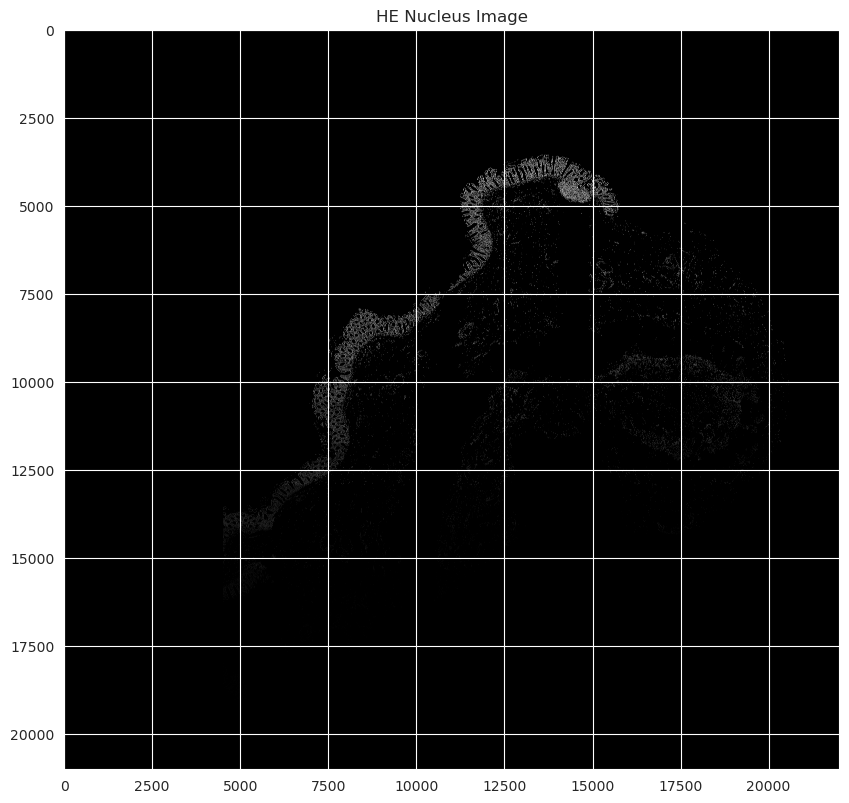

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(sdata.images["HE_original"][0], cmap="gray")
plt.title("HE Original Image")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(sdata.images["HE_nuc_original"][0], cmap="gray")
plt.title("HE Nucleus Image")
plt.show()


### **Step 4: Preprocessing for Visualization**
Before registration, we preprocess the `HE_original` and `HE_nucleus` images by normalizing them to the range [0, 255] and creating an overlay. This allows us to inspect the initial alignment and identify potential issues before proceeding with registration.


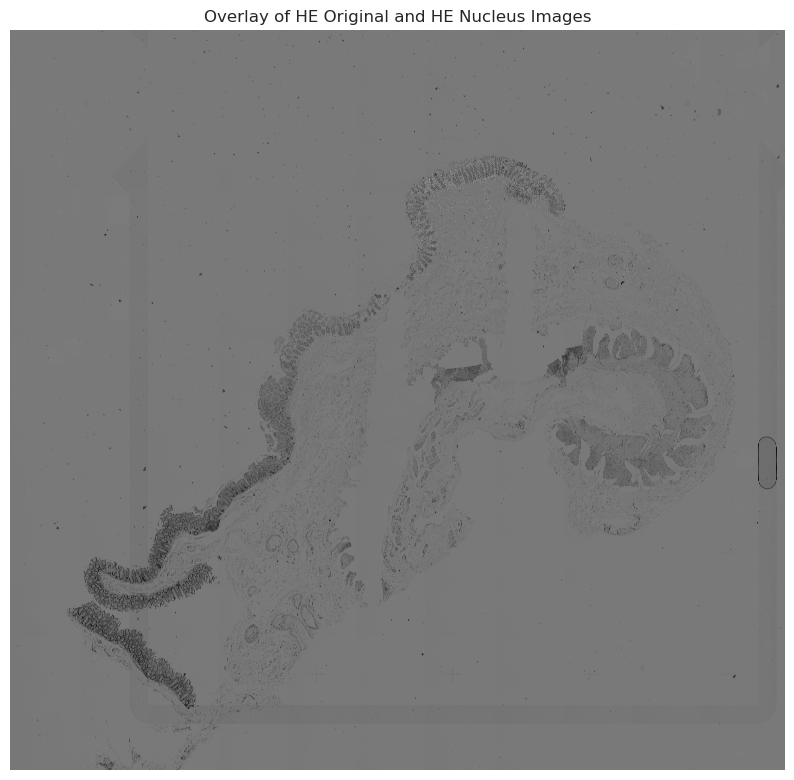

In [7]:
# Normalize both images to the range [0, 255] for visualization
he_original_gray = he_original[0].astype(np.float32)  # Convert to float32 for normalization
he_nucleus_gray = he_nucleus[0].astype(np.float32)    # Convert to float32 for normalization

# Apply normalization
he_original_gray = cv2.normalize(he_original_gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
he_nucleus_gray = cv2.normalize(he_nucleus_gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Create an overlay using cv2.addWeighted
overlay = cv2.addWeighted(he_original_gray, 0.5, he_nucleus_gray, 0.5, 0)

# Plot the overlay
plt.figure(figsize=(10, 10))
plt.imshow(overlay, cmap='gray')
plt.title("Overlay of HE Original and HE Nucleus Images")
plt.axis("off")
plt.show()


### **Image Registration Steps**

#### **Step 1: Convert Both Images to Grayscale**
We start by converting the `HE_original` and `HE_nucleus` images to grayscale, which simplifies computations by reducing the dimensionality of the data. Grayscale images contain only intensity information, which is sufficient for feature detection and alignment since feature detectors can focus solely on intensity variations, such as edges and corners.

#### **Step 2: Detect Keypoints and Descriptors**
We detect distinctive features, called **keypoints**, in each image and compute a **descriptor** for each, which is a numerical vector describing the appearance of the feature. This allows us to find corresponding points between two images, even if the images have different lighting conditions, scales, or orientations. Here, we use **ORB (Oriented FAST and Rotated BRIEF)**, which is computationally efficient and effective for matching.

#### **Step 3: Match Features Between Images**
Using the descriptors, we find matching features between the two images by comparing descriptors from one image to those in the other. The **BFMatcher (Brute Force Matcher)** algorithm computes the similarity of every pair of descriptors and selects the closest matches. Sorting by distance ensures we prioritize the most similar matches.

#### **Step 4: Select Top Matches**
To improve alignment quality, we only retain the best matches with the lowest distances, ensuring the transformation calculation is based on the most reliable correspondences. Filtering by distance helps eliminate outliers (i.e., incorrect matches) and focuses on strong, confident feature correspondences.

#### **Step 5: Extract Matching Keypoints**
We extract the coordinates of the keypoints from both images for all selected matches. Keypoints provide spatial information about features in the images, and by aligning these keypoints, we can calculate the transformation needed to register the images.

#### **Step 6: Calculate the Homography Matrix**
We calculate a **homography matrix**, a 3x3 transformation matrix that maps points in one image to their corresponding points in the other, using the RANSAC (RANdom SAmple Consensus) algorithm. Homography captures transformations like rotation, translation, scaling, and perspective distortion, while RANSAC ensures that only inliers (correct matches) are used to compute the transformation, making the alignment more accurate.

#### **Step 7: Warp the Nucleus Image**
Using the homography matrix, we transform the `HE_nucleus` image so that it aligns with the coordinate system of the `HE_original` image, a process called **warping**. Warping applies the calculated transformation to every pixel in the `HE_nucleus` image, mapping it to the corresponding location in the `HE_original` image for spatial alignment.

#### **Step 8: Overlay the Aligned Images**
We visually combine the aligned `HE_nucleus` image and the `HE_original` image using OpenCV’s `cv2.addWeighted` function to create an overlay. This allows us to validate the alignment visually, where any misalignment will appear as a mismatch in the blended image.

#### **Step 9: Display the Aligned Overlay**
Finally, we display the overlay to visually confirm that the images are correctly aligned. Visualization provides immediate feedback on the effectiveness of the registration process, helping identify issues such as poor alignment or feature detection errors.
